## Last homework

This week we will apply techniques learned during the semester as a recap of the learned methods. We will use a dataset from the paper "Hurricane-induced selection on the morphology of an island lizard", where body parameters of lizards are measured on an island before and after the hurricane. We will make binary predictions if a lizard was measured before of after the hurricane in the upcoming tasks.

When a task is not fully described, try to come up with a reasonable solution!

Data source: https://www.nature.com/articles/s41586-018-0352-3#Sec7

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.gridspec as gridspec

from IPython.display import display

In [2]:
from hw_utils import *

In [3]:
import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [4]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [5]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')
rocket_cmap = sns.color_palette('rocket', as_cmap=True)

target_colors = np.array([cm.magma(0.5), cm.magma(0.75), cm.magma(0.93)])
feature_colors = np.array([rocket_cmap(0.17), cm.magma(0.45), cm.magma(0.60), cm.magma(0.75)])

## 1. Load & prepare data
 - load the provided dataset
 - look for missing values, handle them! Be careful! (You can screw up the whole assignment here)
 - We will make binary predictions if a lizard was before of after the hurricane in the upcoming tasks. 
 - Convert all the features to numeric or binary features.
 - get rid of the ID column

### 1./a. Load and explore data

In [6]:
f = os.listdir(data)[0]
df = pd.read_csv(data + f)

In [7]:
display(df.head())
display(df.tail())

,ID,Hurricane,Origin,Sex,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,...,FingerArea2,FingerArea3,ToeArea1,ToeArea2,ToeArea3,MeanFingerArea,MeanToeArea,SumFingers,SumToes,MaxFingerForce
0,537,After,Pine Cay,Male,48.69,10.39,11.87,7.52,7.43,8.66,...,1.338,1.339,2.529,2.402,2.369,1.332667,2.433333,2.663,4.791,0.116
1,539,After,Pine Cay,Female,40.31,8.66,9.79,6.18,6.20,8.01,...,0.950,0.972,1.498,1.525,1.530,0.961333,1.517667,2.595,3.678,0.048
2,540,After,Pine Cay,Male,58.30,12.87,14.76,9.45,9.58,11.72,...,2.702,2.685,4.157,4.140,3.996,2.631333,4.097667,7.347,4.682,0.424
3,541,After,Pine Cay,Female,43.15,8.55,10.29,6.60,6.26,7.43,...,1.175,1.186,1.898,1.871,1.867,1.177667,1.878667,2.786,5.378,0.171
4,542,After,Pine Cay,Female,45.51,10.26,11.02,6.89,7.02,7.71,...,1.357,1.420,2.627,2.435,2.529,1.384333,2.530333,3.575,6.646,0.014


,ID,Hurricane,Origin,Sex,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,...,FingerArea2,FingerArea3,ToeArea1,ToeArea2,ToeArea3,MeanFingerArea,MeanToeArea,SumFingers,SumToes,MaxFingerForce
159,WC66,Before,Water Cay,Female,43.04,9.23,9.96,6.29,5.72,7.12,...,1.008,1.031,1.170,1.127,1.148,1.018000,1.148333,NaN,NaN,NaN
160,WC69,Before,Water Cay,Female,42.38,9.21,9.80,6.68,6.29,7.38,...,0.920,0.894,1.542,1.526,1.527,0.908667,1.531667,NaN,NaN,NaN
161,WC70,Before,Water Cay,Female,45.74,9.79,10.08,6.61,6.54,8.05,...,1.119,1.146,1.719,1.716,1.703,1.133667,1.712667,NaN,NaN,NaN
162,WC71,Before,Water Cay,Female,40.95,9.04,10.08,6.26,5.52,7.27,...,0.793,0.777,1.227,1.234,1.252,0.784000,1.237667,NaN,NaN,NaN
163,WC72,Before,Water Cay,Female,40.62,8.64,9.77,6.14,6.61,6.91,...,0.842,0.845,1.122,1.203,1.116,0.838000,1.147000,NaN,NaN,NaN


#### Select binary and non-binary columns

In [8]:
# Cut off the ID column
columns = df.columns.delete([0])

# Column types:
# Binary columns     : columns[:3]
# Non-binary columns : columns[3:]

In [9]:
print('Binary feature values:\n'+
      '======================')
print('`Origin`:', np.unique(df['Origin']))
print('`Hurricane`:', np.unique(df['Hurricane']))
print('`Sex`:', np.unique(df['Sex']))

Binary feature values:
`Origin`: ['Pine Cay' 'Water Cay']
`Hurricane`: ['After' 'Before']
`Sex`: ['Female' 'Male']


#### Convert binary columns from string values to ints

In [10]:
# Copy original DataFrame to keep it intact
df_n = df.copy()

In [11]:
# Create a map for binary values and apply it on the copied DataFrame
map_origin = {'Pine Cay' : 0, 'Water Cay' : 1}
map_hurricane = {'Before' : 0, 'After' : 1}
map_sex = {'Female' : 0, 'Male' : 1}

df_n['Origin'] = df['Origin'].map(map_origin)
df_n['Hurricane'] = df['Hurricane'].map(map_hurricane)
df_n['Sex'] = df['Sex'].map(map_sex)

### 1./b. Explore NaN values

In [12]:
# Create a mask to analyze missing entries easier
nan_mask = df_n.isna()
nan_count = nan_mask.sum()
print('Count of missing values:\n' +
      '========================')
print(tabulate([[c, nan_count[c]] for c in nan_count.index], headers=['Feature', 'Count of NaNs']))

Count of missing values:
Feature           Count of NaNs
--------------  ---------------
ID                            0
Hurricane                     0
Origin                        0
Sex                           0
SVL                           0
Femur                         0
Tibia                         0
Metatarsal                    0
LongestToe                    0
Humerus                       0
Radius                        0
Metacarpal                    0
LongestFinger                 0
FingerCount                   1
ToeCount                      1
FingerArea1                   1
FingerArea2                   1
FingerArea3                   1
ToeArea1                      1
ToeArea2                      1
ToeArea3                      1
MeanFingerArea                1
MeanToeArea                   1
SumFingers                   73
SumToes                      73
MaxFingerForce               74


In [13]:
## Create a dataframe to mark NaN values
df_nan = np.array(df_n[columns].isna()).T

## Create a mask for hurricane entries
# Get indeces of hurricane
mask = (df_n['Hurricane'] == 1)
inds = np.array(mask[mask.values].index)
# Create mask to mark rows with Hurricane == 1 values as 1s
df_mask = np.zeros_like(df_nan).astype(int)
df_mask.T[inds] = np.ones((inds.size, columns.size))

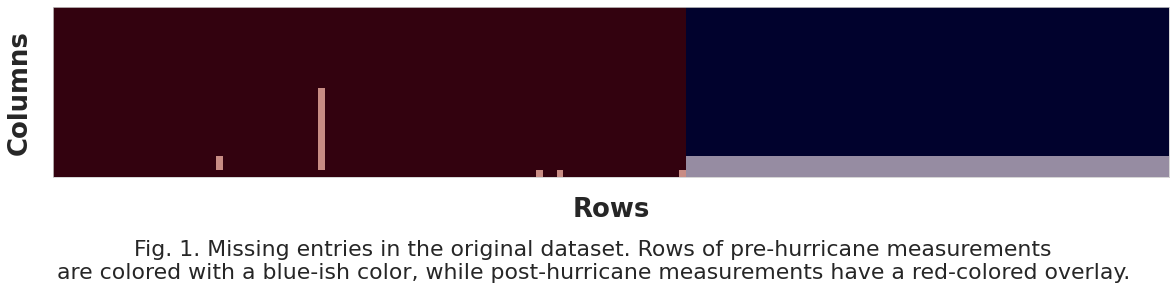

In [14]:
fig, axes = plt.subplots(figsize=(20,20))
axes.set_aspect('equal')

axes.imshow(np.array(df_n[columns].isna()).T)
axes.imshow(df_mask, cmap=cm.seismic, alpha=0.4)

# Remove XY ticks for now
axes.set_xticks([])
axes.set_yticks([])

# Lapelpad needed because of the removed ticks
lp = 20
axes.set_xlabel('Rows', fontsize=axislabelsize, fontweight='bold', labelpad=lp)
axes.set_ylabel('Columns', fontsize=axislabelsize, fontweight='bold', labelpad=lp)

plt.suptitle('Fig. 1. Missing entries in the original dataset. Rows of pre-hurricane measurements\n' +
             'are colored with a blue-ish color, while post-hurricane measurements have a red-colored overlay.',
             fontsize=axistitlesize+2, y=0.4)

plt.show()

### 1./c. Inspect distribution of non-binary values before and after the hurricane

In [15]:
# 'a' and 'b' indicates the before and after hurricane measurements
hist = {'b': {}, 'a': {}}
bins = {'b': {}, 'a': {}}
width = {'b': {}, 'a': {}}
center = {'b': {}, 'a': {}}

#
# THROWS RuntimeWarning, because some pre-hurricane values are completely missing from the dataset.
# Can be fully ignored here.
#
for t in ['b', 'a']:
    df_cut = df_n[~mask] if t=='b' else df_n[mask]
    for c in columns[3:]:
        hist[t][c], bins[t][c] = np.histogram(df_cut[c][~df_cut[c].isna()], bins=10, density=True)
        width[t][c] = 0.8 * (bins[t][c][1] - bins[t][c][0])
        center[t][c] = (bins[t][c][:-1] + bins[t][c][1:]) / 2

/home/masterdesky/miniconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


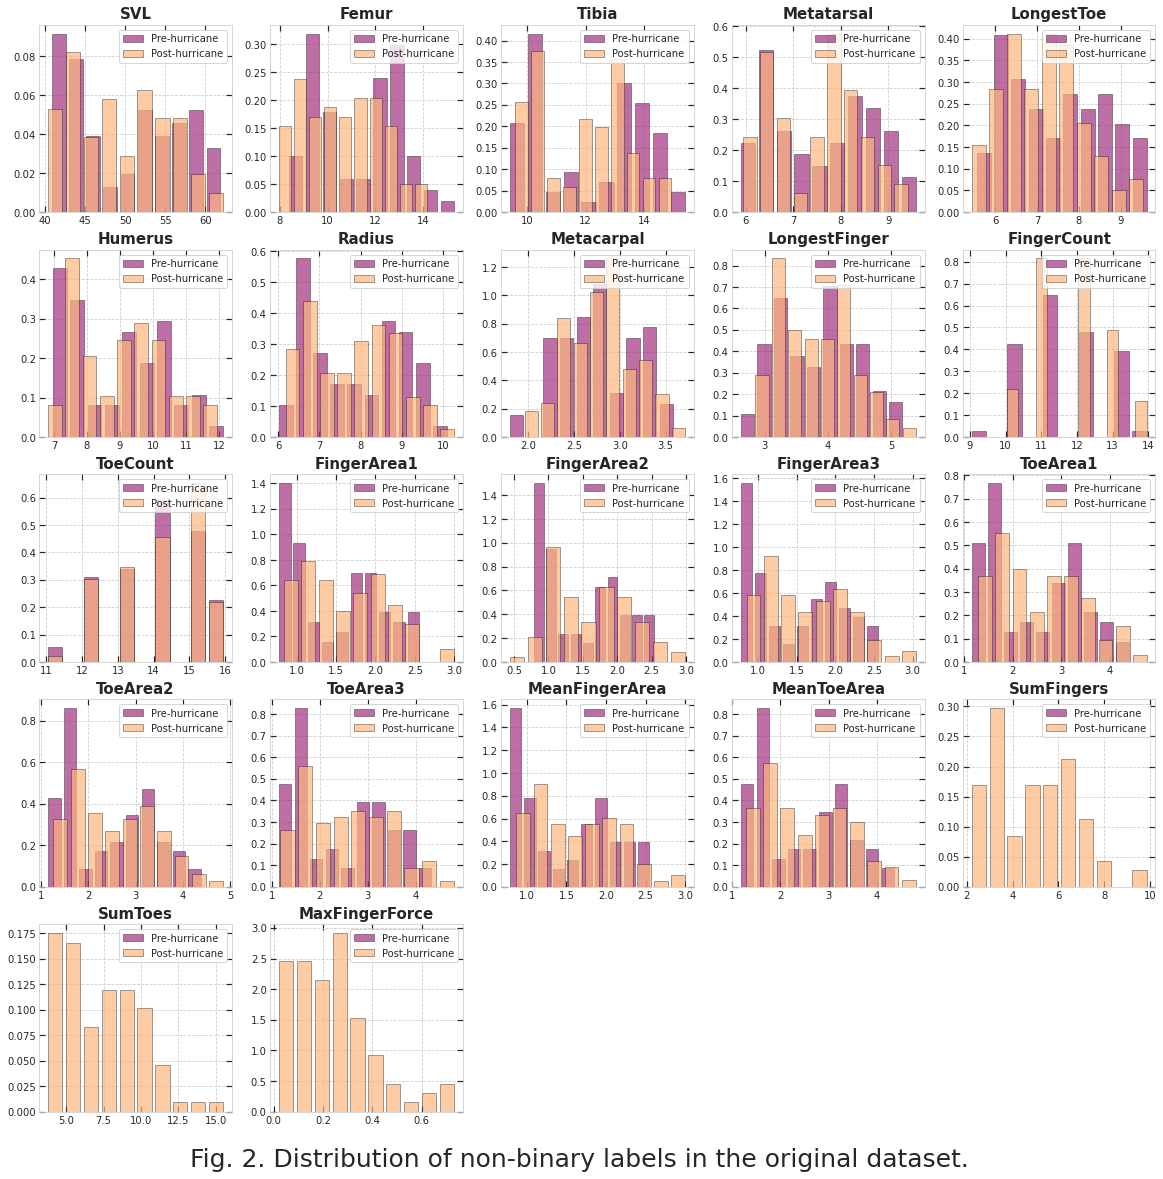

In [16]:
ncols = 5
nrows = (columns[3:].size+ncols-1)//ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

colors = [cm.magma(0.45), cm.magma(0.85)]
labels = ['Pre-hurricane', 'Post-hurricane']
# Loop through axes/features
for col_i, ax in enumerate(axes.reshape(-1)):
    # Turn off all surplus axes
    if col_i < columns[3:].size:
        col = columns[3:][col_i]
        # Loop through the two before-after datasets
        # ('t' here supposed to mean "time")
        for t_i, t in enumerate(['b', 'a']):
            ax.bar(center[t][col], hist[t][col], width=width[t][col],
                   label=labels[t_i],
                   color=colors[t_i], alpha=0.7,
                   ec='black', lw=0.5, align='center')
            ax.set_title(col, fontsize=axistitlesize-5, fontweight='bold')
            ax.set_ylabel('')
            
            ax.legend(loc='upper right')

    else : ax.axis('off')
plt.suptitle('Fig. 2. Distribution of non-binary labels in the original dataset.',
             fontsize=axistitlesize+5, y=0.1)
plt.show()

### 1./d. Actually handling missing values

The columns from `FingerCount` to `MeanToeArea` misses only one value in each column. The image above shows, that these values are all missing from the same row, thus we might want to consider removing it from the dataset. The real problem is caused by the columns `SumFingers`, `SumToes` and `MaxFingerForce`, which is probably referred to as "you can screw up the whole assignment here trollolo" in the task description.

We're basically studying here that what characteristics do those reptiles have, which survives/get through the event of a hurricane. These reptiles will be maybe the stronger/more viable types, which can grip onto something for a longer time and with more force and stability - to stand against the winds in the hurricane. It could happen, that much smaller lizards with less grip force have higher survival rate, since they can hide easier than bigger (and thus stronger) animals. Also the distribution of these features can easily differ before and after the hurricane, since animals are probably much more tired, etc. We'll see the truth soon...

The problem is, that at the end of the day, the `SumFingers`, `SumToes` and `MaxFingerForce` features will probably have big impact on the model and we have to consider to keep them at any cost. Figure 1. and Figure 2. shows however, that we have literally no measurements about them before the hurricane. In contrast of everything I've written in the last two paragraphs, this indicates us that we probably should drop these features from the dataset. I really do hope, I won't screw up the dataset with this...

#### Address the rows and features with lot of missing values

In [17]:
# Check number of missing elements in rows
print('Missing number of values per rows:\n' +
      '==================================')
df_miss_r = np.array(df_n.isna()).sum(axis=1)
print(df_miss_r)

Missing number of values per rows:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3]


In [18]:
# Check number of missing elements in rows
print('Missing number of values per columns:\n' +
      '==================================')
df_miss_c = np.array(df_n.isna()).sum(axis=0)
print(df_miss_c)

Missing number of values per columns:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1 73
 73 74]


In [19]:
# Remove the row with lot of missing values
df_fin = df_n.drop(labels=[
                    np.where(
                        df_miss_r == df_miss_r.max()
                    )[0][0]
                ])
# Fill back created hole in indeces
df_fin.index = pd.Int64Index(np.arange(0,len(df_fin)))

# Remove features with lot of missing values
df_fin = df_fin.drop(columns=['SumFingers', 'SumToes', 'MaxFingerForce'])

# Final set of features
# (Cut ID columns)
features = df_fin.columns[1:]
df_fin = df_fin[features]
print('Final set of features:\n' +
      '======================')
print(features)

Final set of features:
Index(['Hurricane', 'Origin', 'Sex', 'SVL', 'Femur', 'Tibia', 'Metatarsal',
       'LongestToe', 'Humerus', 'Radius', 'Metacarpal', 'LongestFinger',
       'FingerCount', 'ToeCount', 'FingerArea1', 'FingerArea2', 'FingerArea3',
       'ToeArea1', 'ToeArea2', 'ToeArea3', 'MeanFingerArea', 'MeanToeArea'],
      dtype='object')


### 1./e. Check our dataset after the preprocession

In [20]:
## Create a dataframe to mark NaN values
df_nan = np.array(df_fin.isna()).T

## Create a mask for hurricane entries
# Get indeces of hurricane
mask = (df_fin['Hurricane'] == 1)
inds = np.array(mask[mask.values].index)
# Create mask to mark rows with Hurricane == 1 values as 1s
df_mask = np.zeros_like(df_nan).astype(int)
df_mask.T[inds] = np.ones((inds.size, features.size))

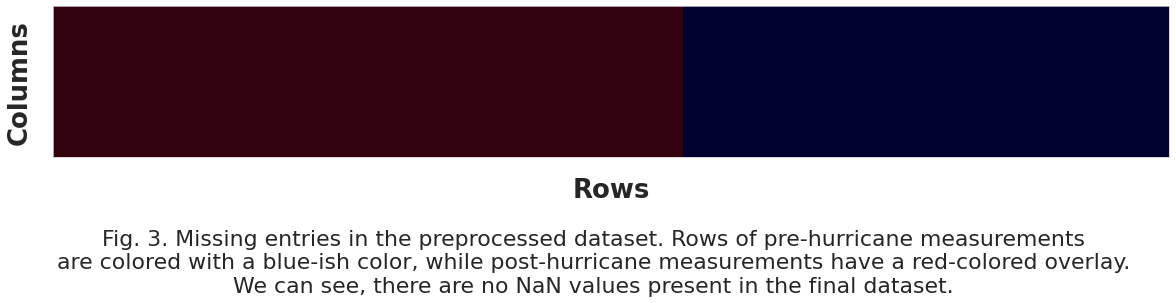

In [21]:
fig, axes = plt.subplots(figsize=(20,20))
axes.set_aspect('equal')

axes.imshow(np.array(df_fin[features].isna()).T)
axes.imshow(df_mask, cmap=cm.seismic, alpha=0.4)

# Remove XY ticks for now
axes.set_xticks([])
axes.set_yticks([])

# Lapelpad needed because of the removed ticks
lp = 20
axes.set_xlabel('Rows', fontsize=axislabelsize, fontweight='bold', labelpad=lp)
axes.set_ylabel('Columns', fontsize=axislabelsize, fontweight='bold', labelpad=lp)

plt.suptitle('Fig. 3. Missing entries in the preprocessed dataset. Rows of pre-hurricane measurements\n' +
             'are colored with a blue-ish color, while post-hurricane measurements have a red-colored overlay.\n' +
             'We can see, there are no NaN values present in the final dataset.',
             fontsize=axistitlesize+2, y=0.4)

plt.show()

## 2. T-SNE
 - embed the data points into a 2D space via T-SNE (preprocess the data if needed). For embedding, use only the numerical features (So do not use Sex, Hurricane and Origin features)
 - what is common in the clusters that we got? visualize the embedded points by using different colour for the different fetautre values (eg on a plot show the female gekkos with red and the male ones with blue). Explore at least 4 features! Do we get separation by the Hurricane variable?

In [22]:
from matplotlib.lines import Line2D

from sklearn import decomposition
from sklearn.manifold import TSNE

In [23]:
# Use only non-binary values
df_tsne = df_fin[features[3:]]

In [24]:
%%time
# Perform t-SNE in the scaled data with 2 components
df_embedded_variation = []
perplexity = [2, 5, 10, 30, 50, 100]
for p in perplexity:
    df_embedded_variation.append(TSNE(n_components=2, perplexity=p).fit_transform(df_tsne))

CPU times: user 20.5 s, sys: 256 ms, total: 20.8 s
Wall time: 6.94 s


In [25]:
def plot_tsne(f_to_color='Sex',
              fig_text=''):
    
    nrows = 2
    ncols = 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(12*ncols, 12*nrows))

    # scatter point radius
    sc_rad = 9

    # Set a colormap for scatter points
    # Color points by a chosen binary feature
    bin_colors = np.array(['tab:red', 'tab:blue'])
    colors = bin_colors[(df_fin[f_to_color] == 1).astype(int)]
    # Select labels for points
    if f_to_color.lower() == 'sex': _map = map_sex
    elif f_to_color.lower() == 'hurricane': _map = map_hurricane
    elif f_to_color.lower() == 'origin': _map = map_origin
    inv_map = {v: k for k, v in _map.items()}
    labels = list(inv_map.values())

    # Plot the t-SNE domains
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i][j]
            # Select embedding with the correct perplexity
            df_embedded = df_embedded_variation[i*ncols + j]
            x = df_embedded[:,0]
            y = df_embedded[:,1]
            ax.scatter(x, y,
                       color=colors, s=sc_rad**2, alpha=0.7)

            ax.set_title('Perplexity = {0}'.format(perplexity[i*ncols + j]), fontsize=axistitlesize, fontweight='bold')
            ax.set_xlabel('Embedding dim. 1', fontsize=axislabelsize, fontweight='bold', labelpad=15)
            ax.set_ylabel('Embedding dim. 2', fontsize=axislabelsize, fontweight='bold', labelpad=15)
            ax.tick_params(axis='both', which='major', labelsize=axisticksize)

            handles = [Line2D([0], [0], marker='o', color='w', label=labels[0],
                              markerfacecolor=bin_colors[0], markersize=15),
                       Line2D([0], [0], marker='o', color='w', label=labels[1],
                              markerfacecolor=bin_colors[1], markersize=15)]
            ax.legend(loc='best', handles=handles, fontsize=axislegendsize)

    fig.suptitle(fig_text,
                 fontsize=axistitlesize+12, y=0.04)

    plt.show()

#### Coloring by `Sex`

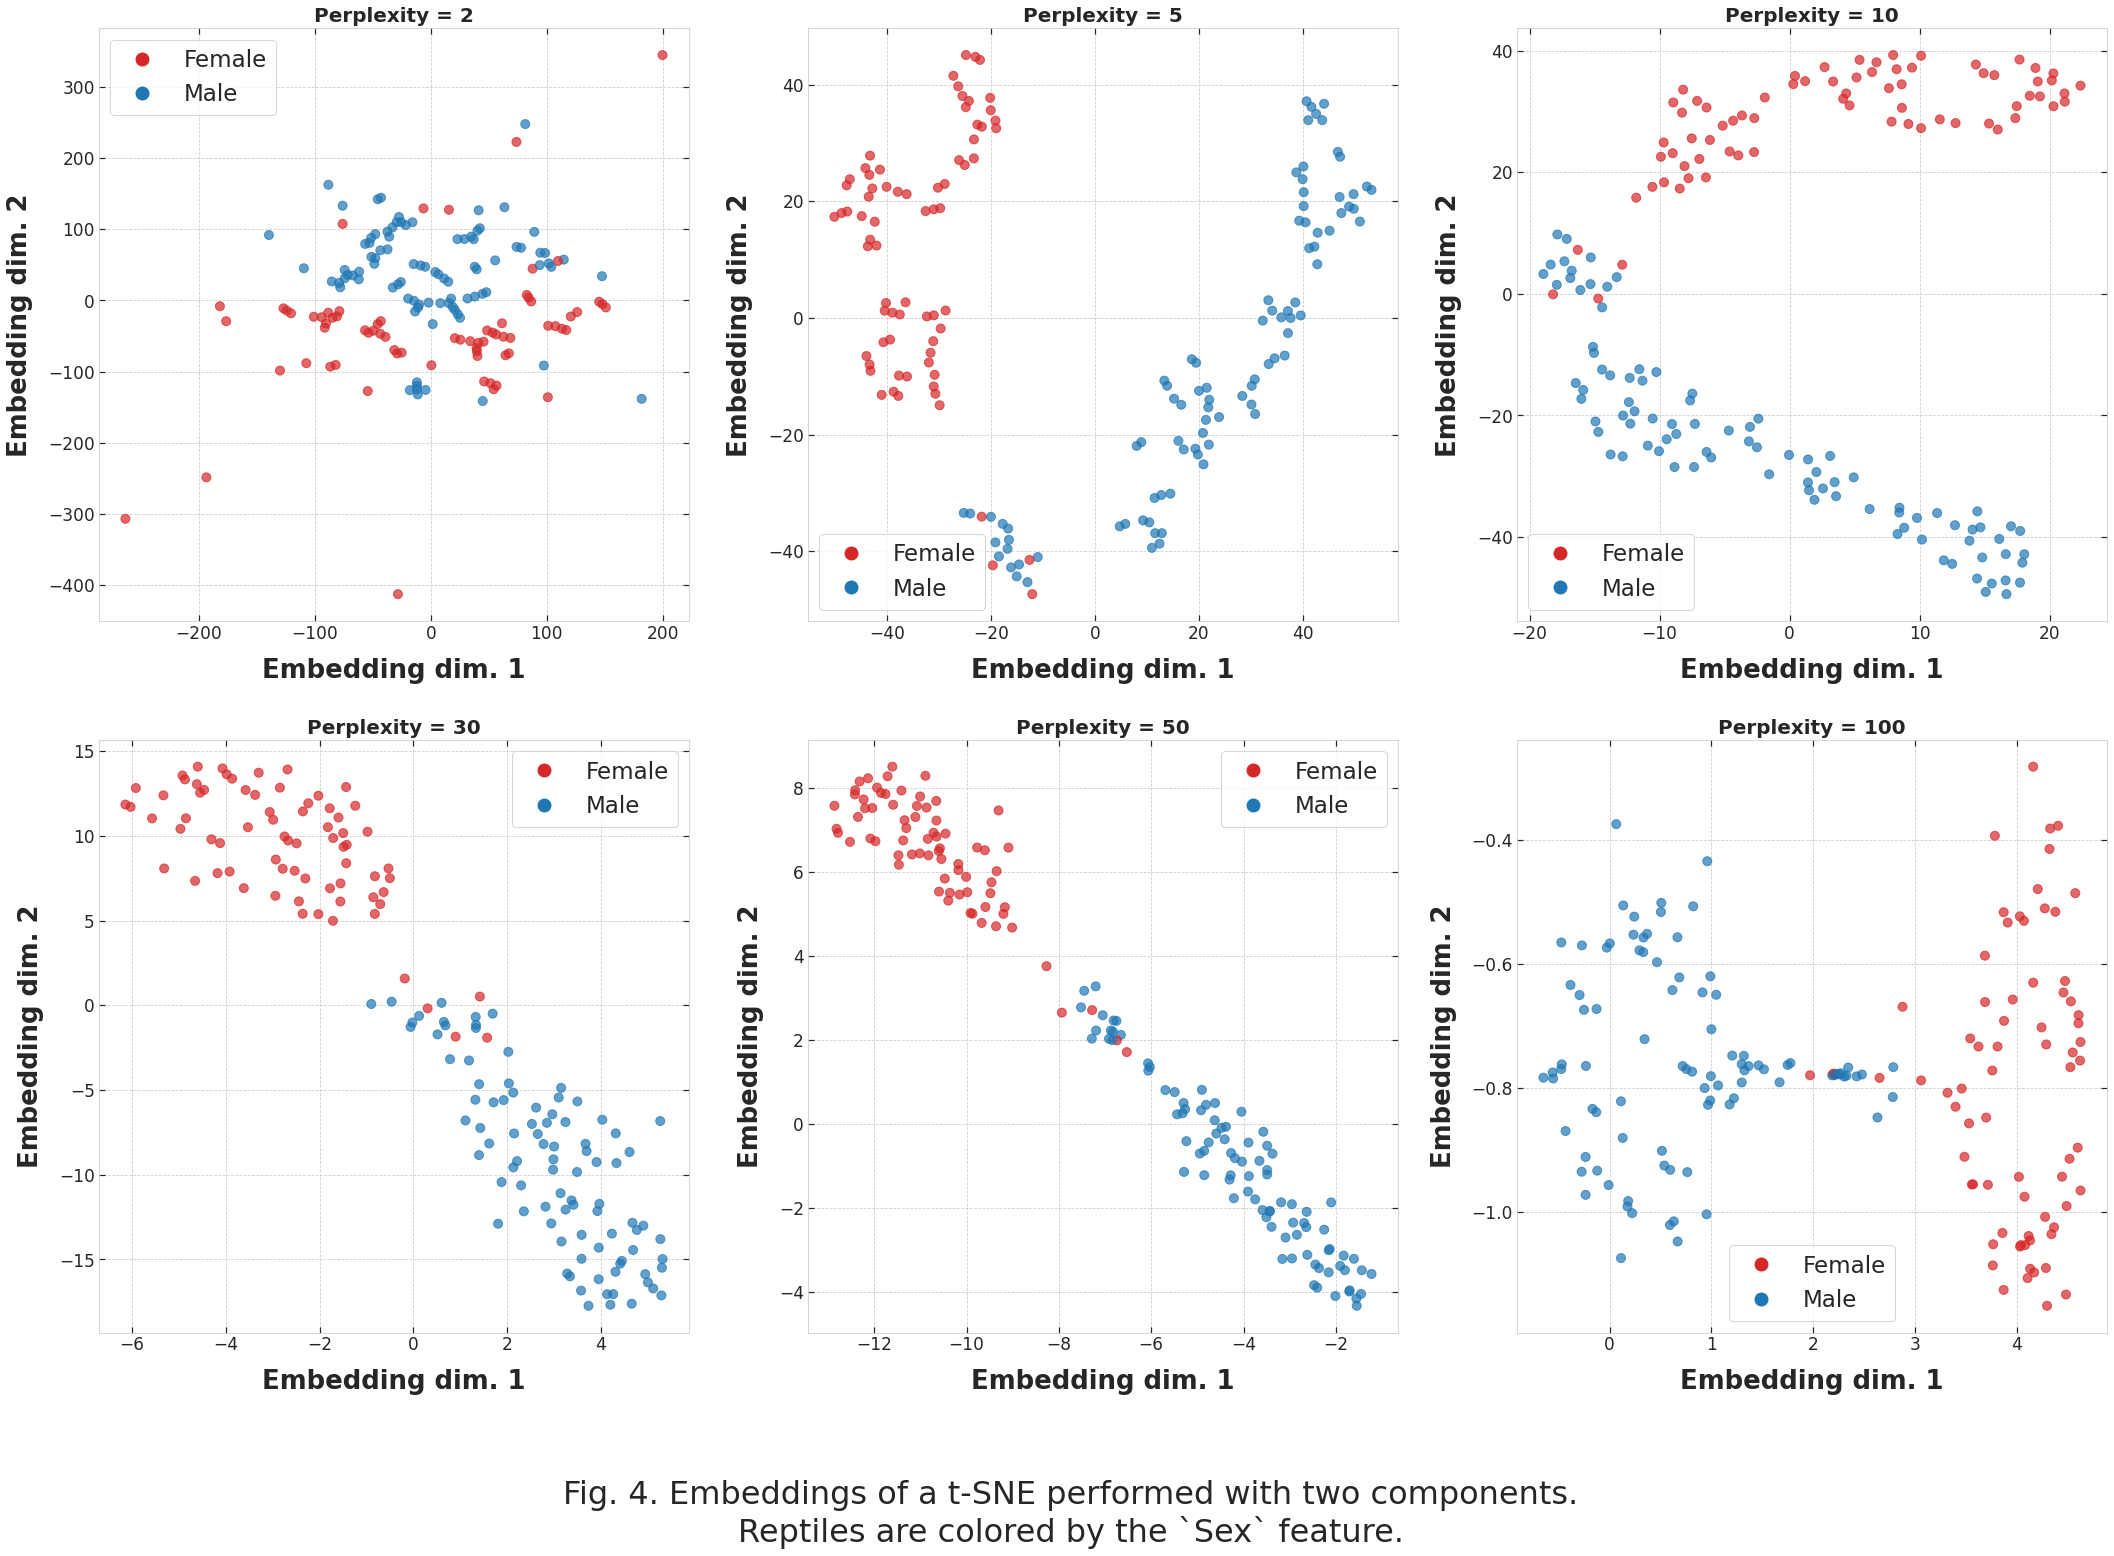

In [26]:
f_to_color = 'Sex'
plot_tsne(f_to_color,
          'Fig. 4. Embeddings of a t-SNE performed with two components.\nReptiles are colored by the `{0}` feature.'.format(f_to_color))

#### Coloring by `Hurricane`

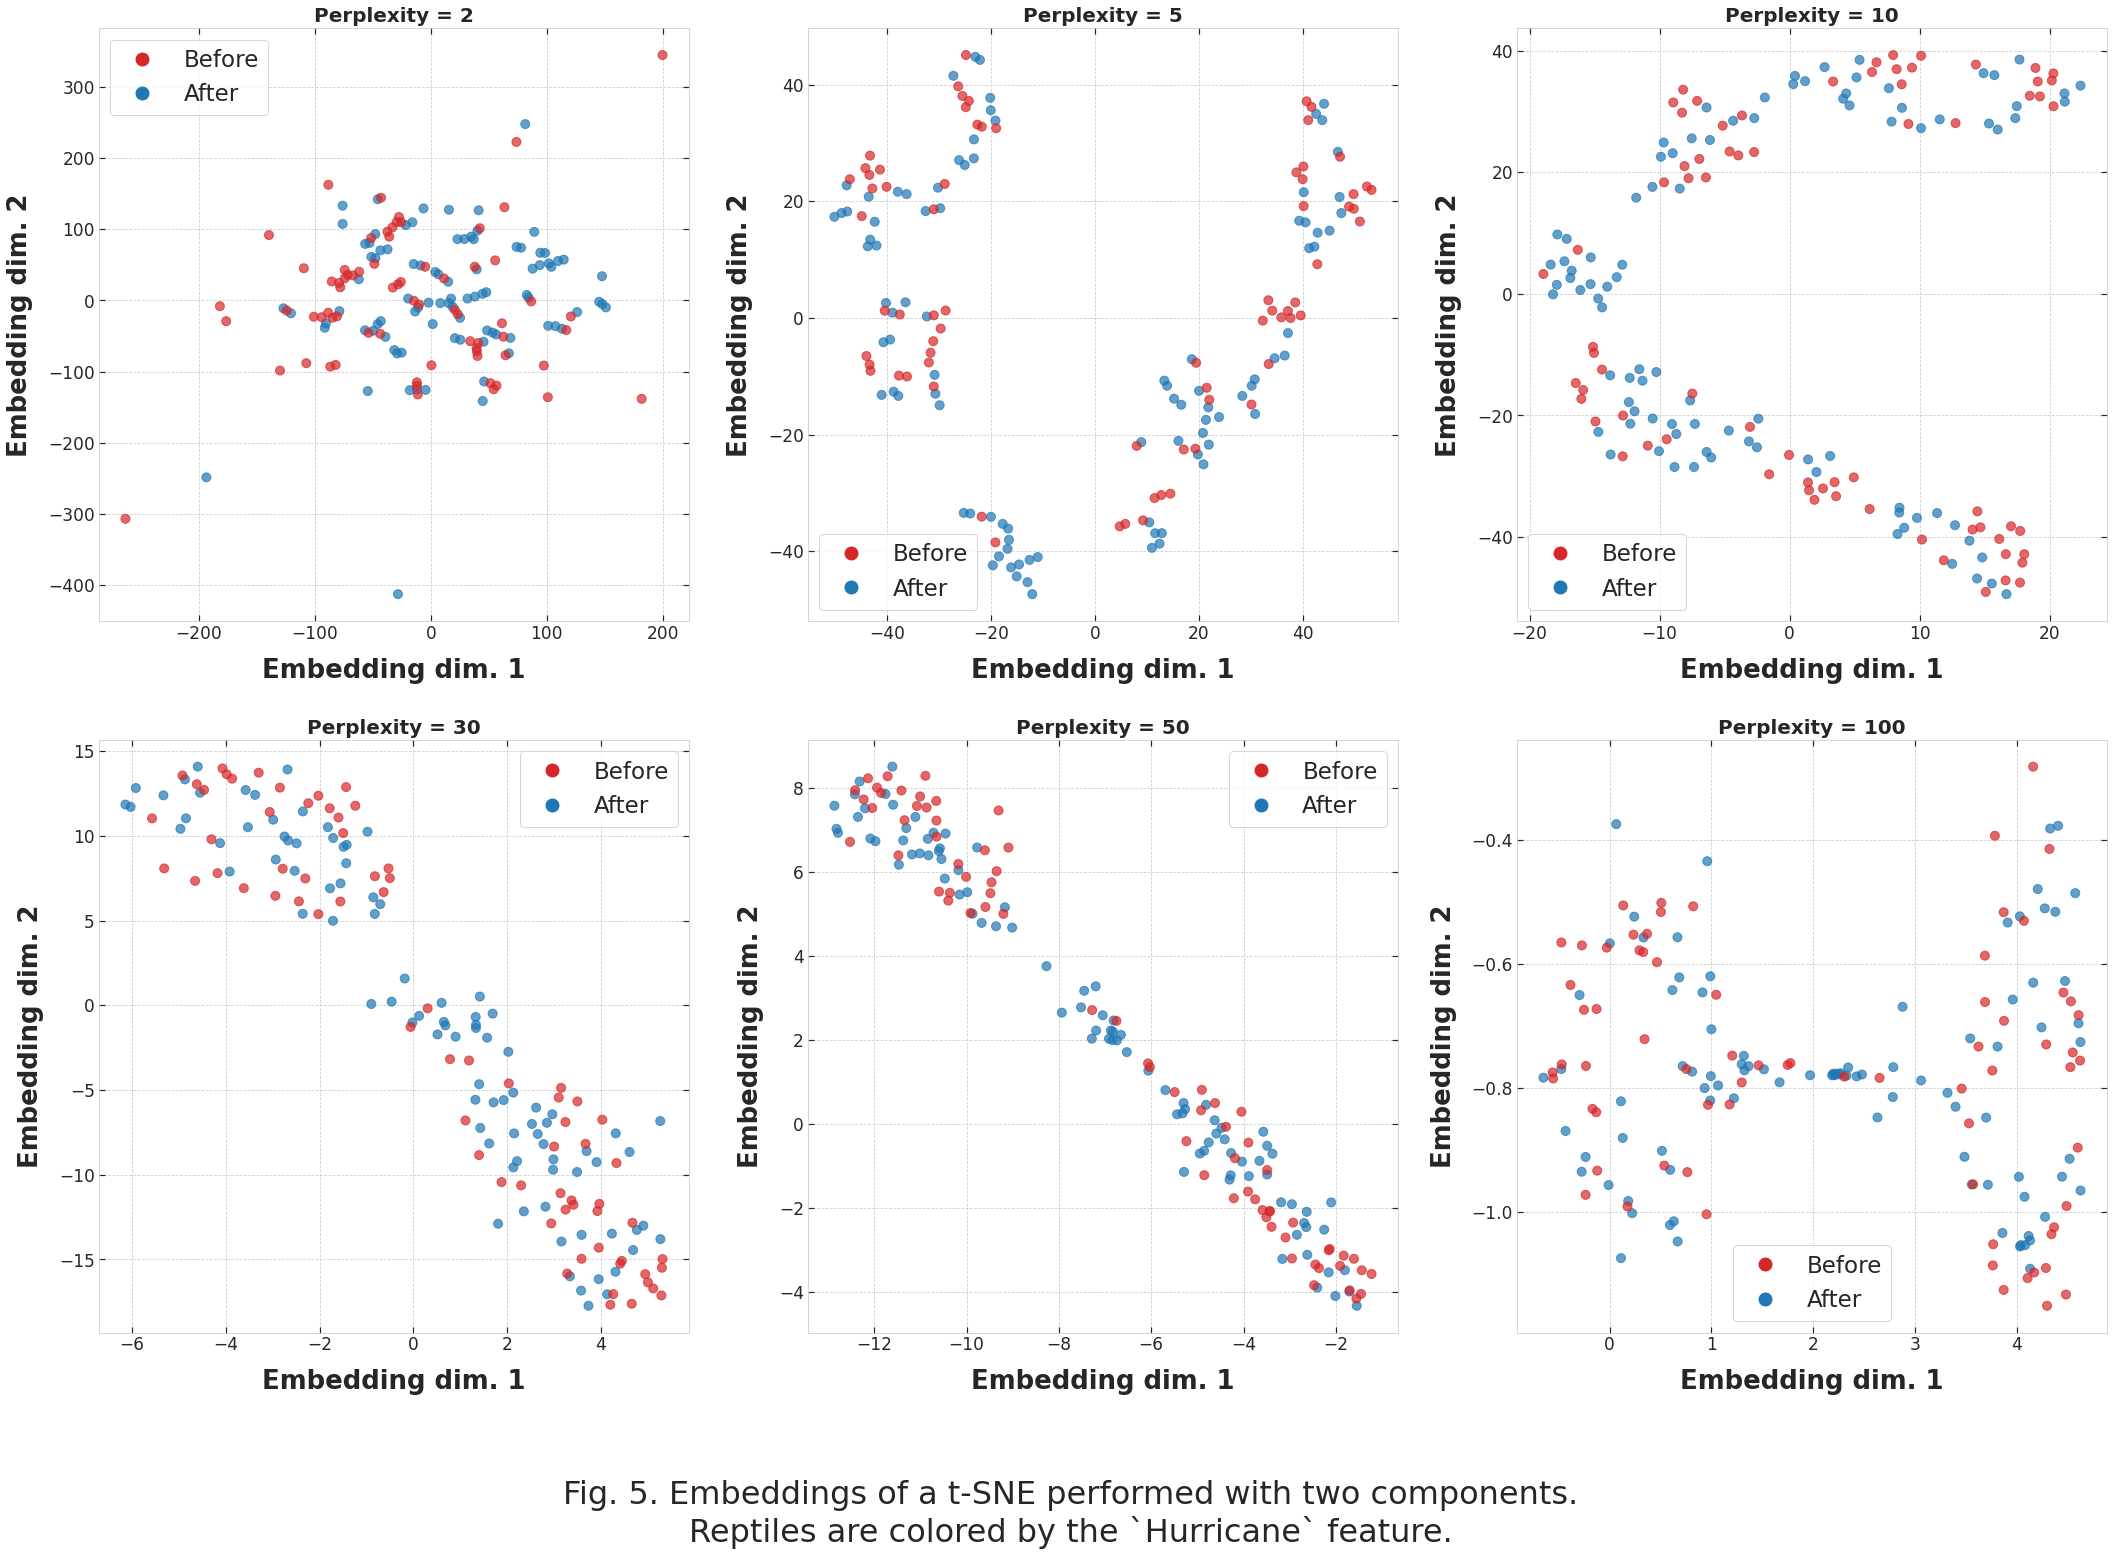

In [27]:
f_to_color = 'Hurricane'
plot_tsne(f_to_color,
          'Fig. 5. Embeddings of a t-SNE performed with two components.\nReptiles are colored by the `{0}` feature.'.format(f_to_color))

#### Coloring by `Origin`

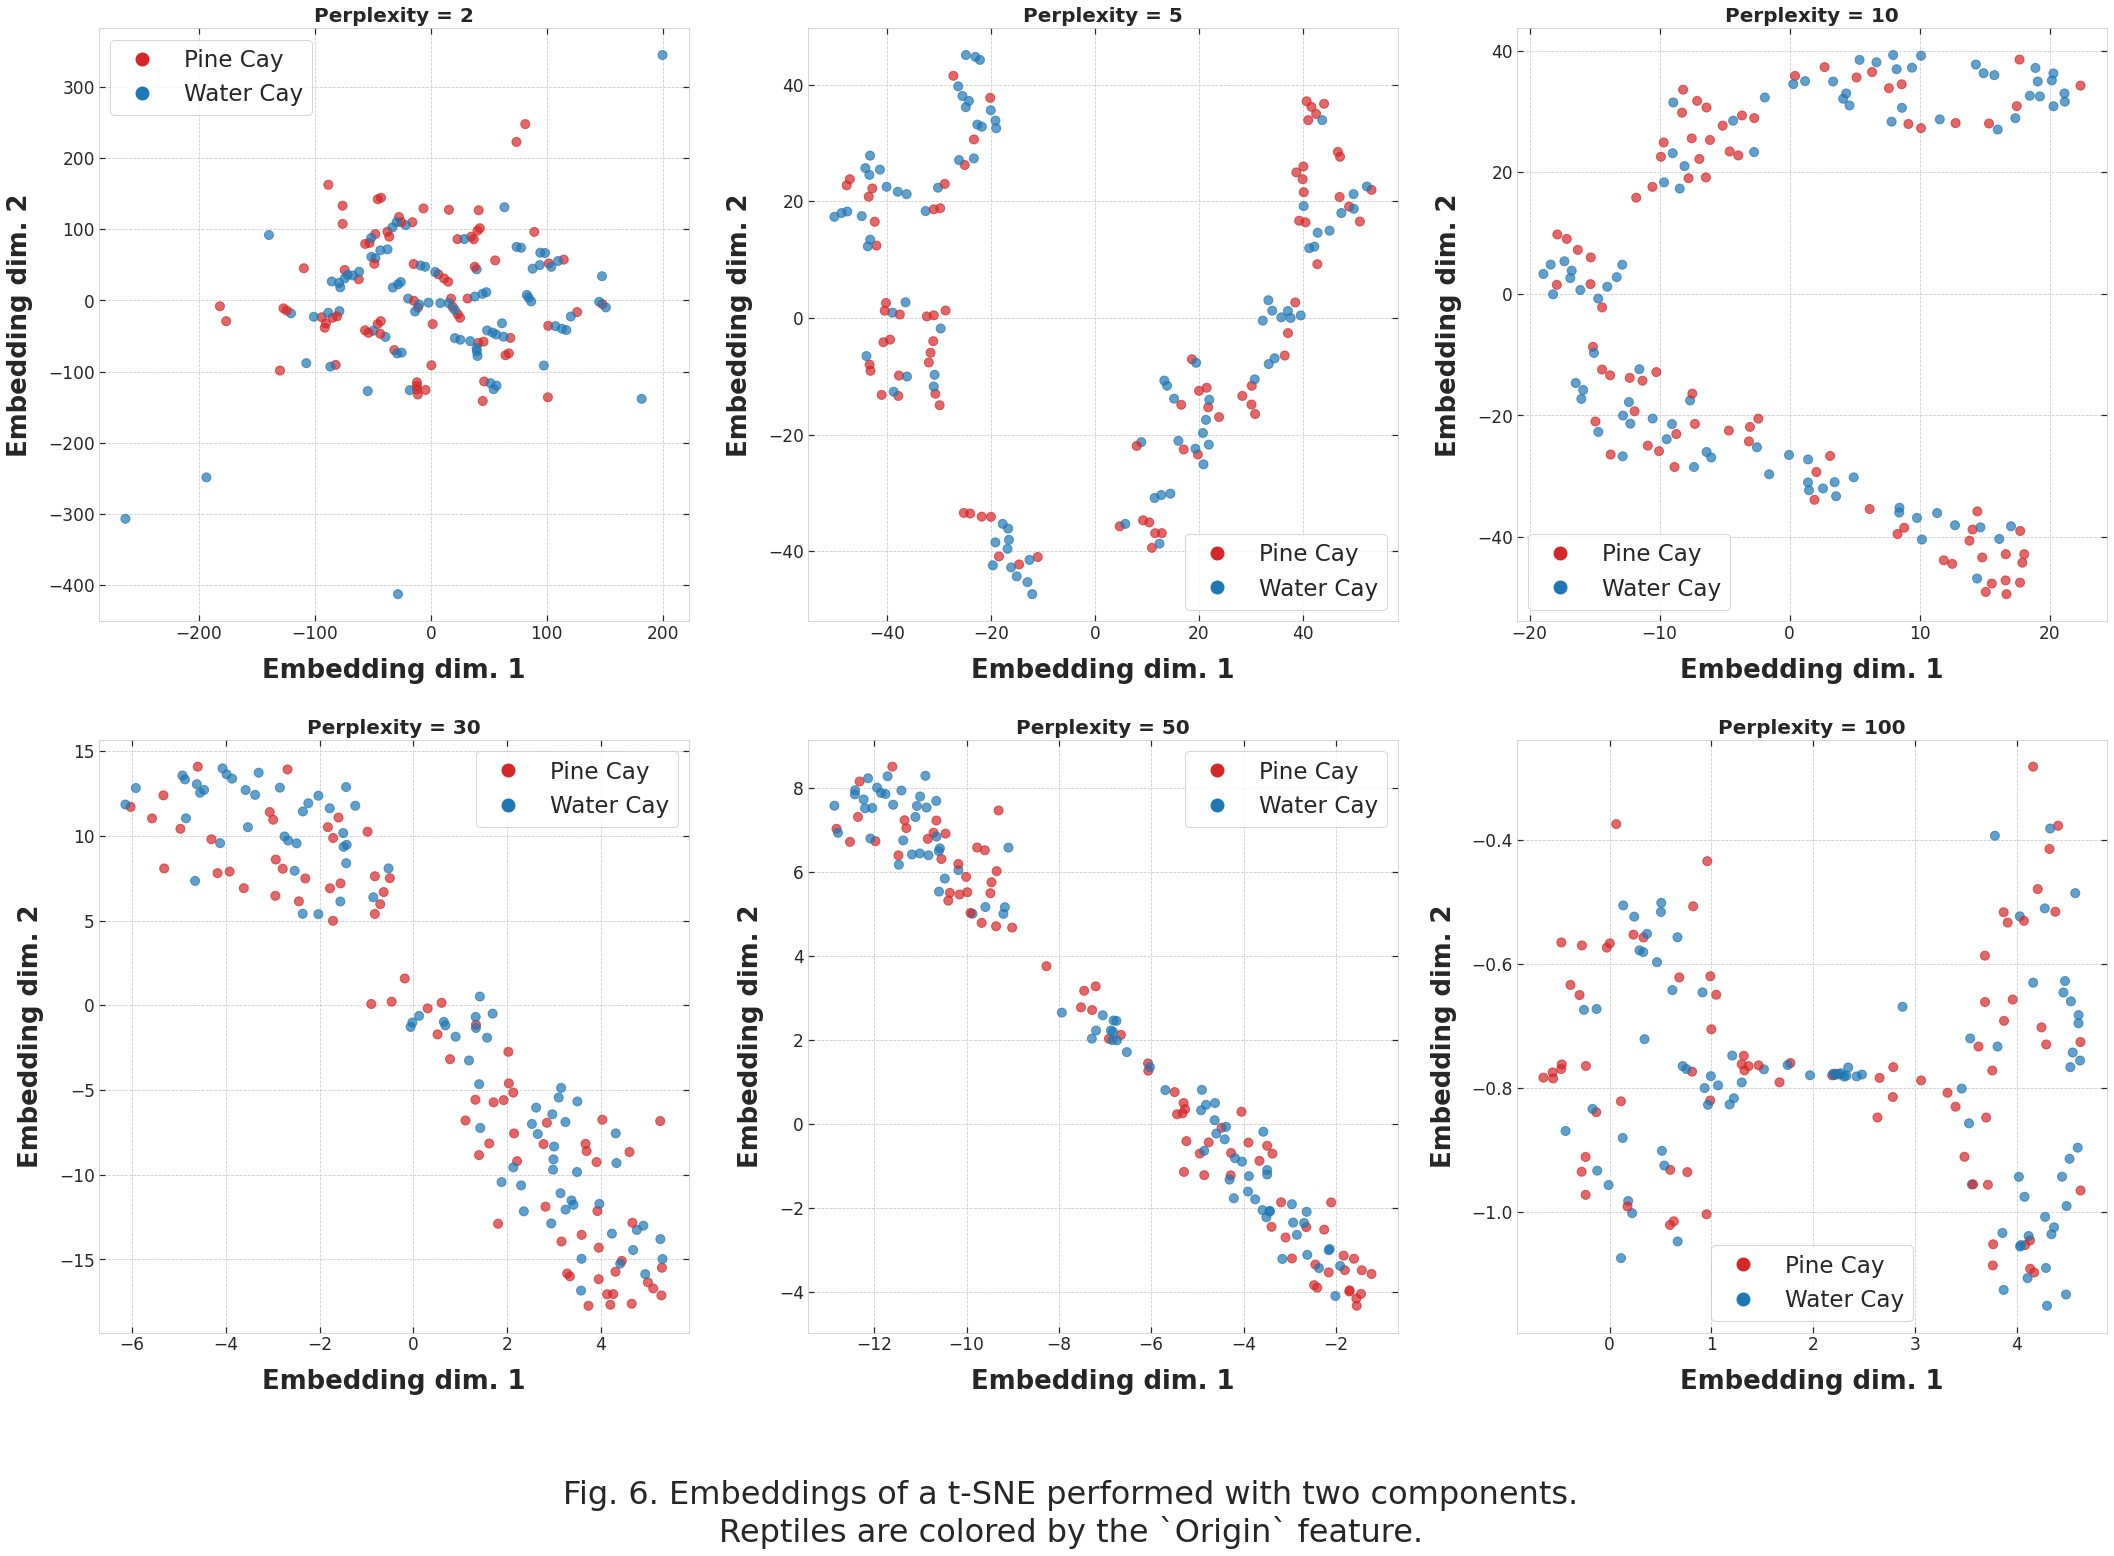

In [28]:
f_to_color = 'Origin'
plot_tsne(f_to_color,
          'Fig. 6. Embeddings of a t-SNE performed with two components.\nReptiles are colored by the `{0}` feature.'.format(f_to_color))

### 3./b. Conclusions

We get a clear separation for sexes for almost every perplexity values. However neither the feature `Origin` nor the target feature `Hurricane` shows any separation...

## 3. Linear model + fine-tune
 - train and generate predictions with a logistic regression model using 5 fold cross validation
 - fine-tune the regularization strength for L2 regularization type!
 - show the ROC curve with the AUC value for the best model that you have found

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [30]:
X = df_fin[features[3:]]
y = df_fin['Hurricane']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
# 5-fold search is needed
folds = 5
cv = KFold(n_splits=folds, shuffle=True, random_state=42)
# LogisticRegression model
model = LogisticRegression(max_iter=1e05, random_state=42, n_jobs=-1)
# Paramters to explored:
# C : regularization strength
param_grid = {
    'C' : np.logspace(-10, 1, 100),
}
# Grid search cross-validation
clf = GridSearchCV(estimator=model,
                   param_grid=param_grid,
                   cv=cv,
                   n_jobs=-1)

In [33]:
%%time
best_model = clf.fit(X_train, y_train).best_estimator_
print('Best model : {0}'.format(best_model))
y_pred = best_model.predict(X_test)

Best model : LogisticRegression(C=0.2782559402207126, max_iter=100000.0, n_jobs=-1,
                   random_state=42)
CPU times: user 237 ms, sys: 24.4 ms, total: 261 ms
Wall time: 5.06 s


In [34]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels=[i for i in range(0,2)])

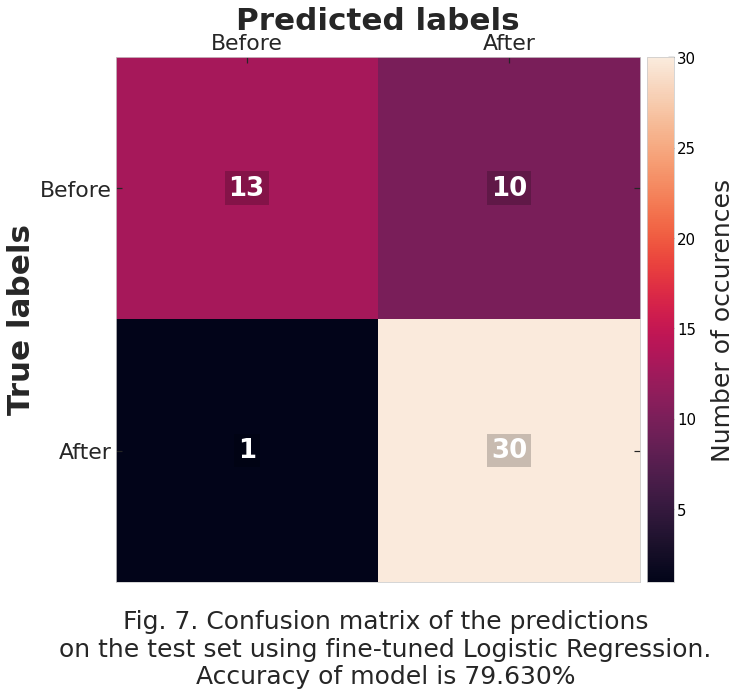

In [35]:
plot_confusion_matrix(conf_mat, y_test, labels=['Before', 'After'],
                      title=('Fig. 7. Confusion matrix of the predictions\n' +
                             'on the test set using fine-tuned Logistic Regression.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)),
                     figsize=10)

In [36]:
fpr_tr, tpr_tr, roc_auc_tr = compute_roc(best_model, X_train, y_train)
fpr_ts, tpr_ts, roc_auc_ts = compute_roc(best_model, X_test, y_test)

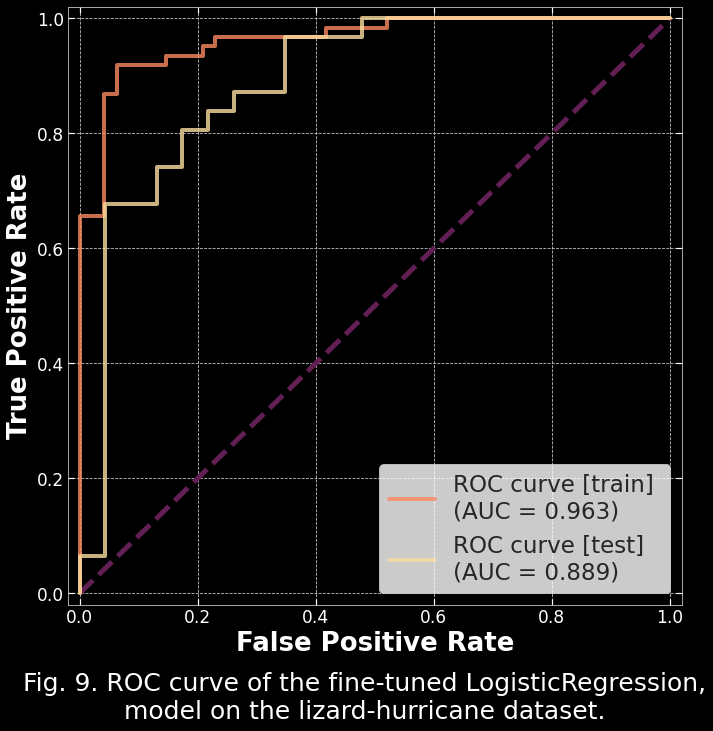

In [37]:
fig, axes = plt.subplots(figsize=(11, 11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot([0, 1], [0, 1], color=rocket_cmap(0.25), lw=5, linestyle='--')

# My model
axes.plot(fpr_tr, tpr_tr,
          label='ROC curve [train] \n(AUC = %0.3f)' % roc_auc_tr,
          color=cm.magma(0.75), lw=4, alpha=0.8)
axes.plot(fpr_ts, tpr_ts,
          label='ROC curve [test] \n(AUC = %0.3f)' % roc_auc_ts,
          color=cm.magma(0.93), lw=4, alpha=0.8)

axes.set_xlim([-0.02, 1.02])
axes.set_ylim([-0.02, 1.02])

axes.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 9. ROC curve of the fine-tuned LogisticRegression,\n' +
             'model on the lizard-hurricane dataset.',
             fontsize=axistitlesize+5, y=0.04, color='white')
    
plt.show()

## 4. SVM + fine-tune
 - train and generate predictions with an SVM model using 5 fold cross validation
 - fine-tune the kernel parameters for 2 selected kernels
 - show the ROC curve with the AUC value for the best model that you have found

In [38]:
from sklearn.svm import SVC

In [39]:
X = df_fin[features[3:]]
y = df_fin['Hurricane']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [41]:
def fit_SVC(kernel='rbf'):
    # 5-fold search is needed
    folds = 5
    cv = KFold(n_splits=folds, shuffle=True, random_state=42)
    # SVC estimator
    model = SVC(kernel=kernel, max_iter=-1, random_state=42)
    # Paramters to explored:
    # C : regularization strength
    param_grid = {
        'C' : np.logspace(-10, 1, 100),
    }
    # Grid search cross-validation
    clf = GridSearchCV(estimator=model,
                       param_grid=param_grid,
                       cv=cv,
                       n_jobs=-1)
    return clf

### 4./a. First kernel: `linear`

In [42]:
kernel = 'linear'
clf = fit_SVC(kernel=kernel)

In [43]:
%%time
best_model = clf.fit(X_train, y_train).best_estimator_
print('Best model : {0}'.format(best_model))
y_pred = best_model.predict(X_test)

Best model : SVC(C=2.154434690031878, kernel='linear', random_state=42)
CPU times: user 168 ms, sys: 8.36 ms, total: 176 ms
Wall time: 701 ms


In [44]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels=[i for i in range(0,2)])

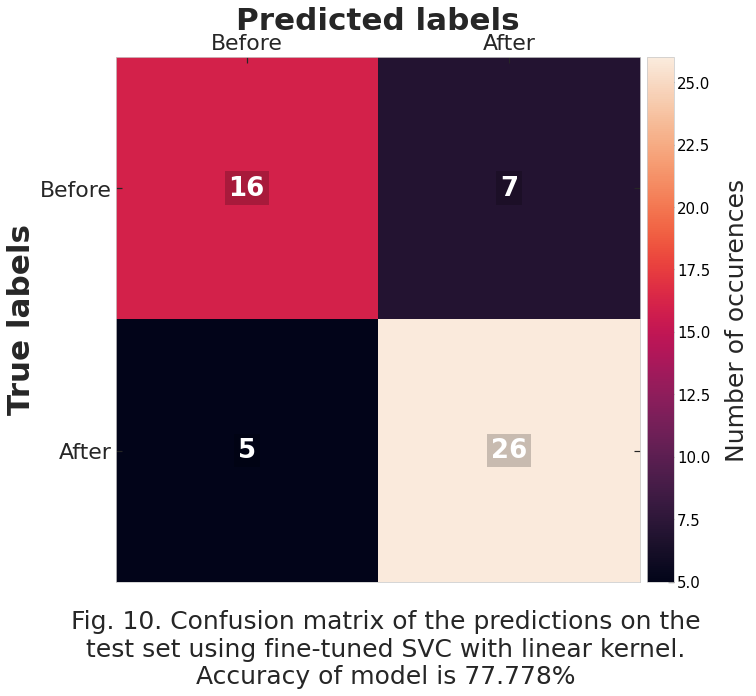

In [45]:
plot_confusion_matrix(conf_mat, y_test, labels=['Before', 'After'],
                      title=('Fig. 10. Confusion matrix of the predictions on the\n' +
                             'test set using fine-tuned SVC with {0} kernel.\n'.format(kernel) +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)),
                     figsize=10)

In [46]:
fpr_tr, tpr_tr, roc_auc_tr = compute_roc(best_model, X_train, y_train)
fpr_ts, tpr_ts, roc_auc_ts = compute_roc(best_model, X_test, y_test)

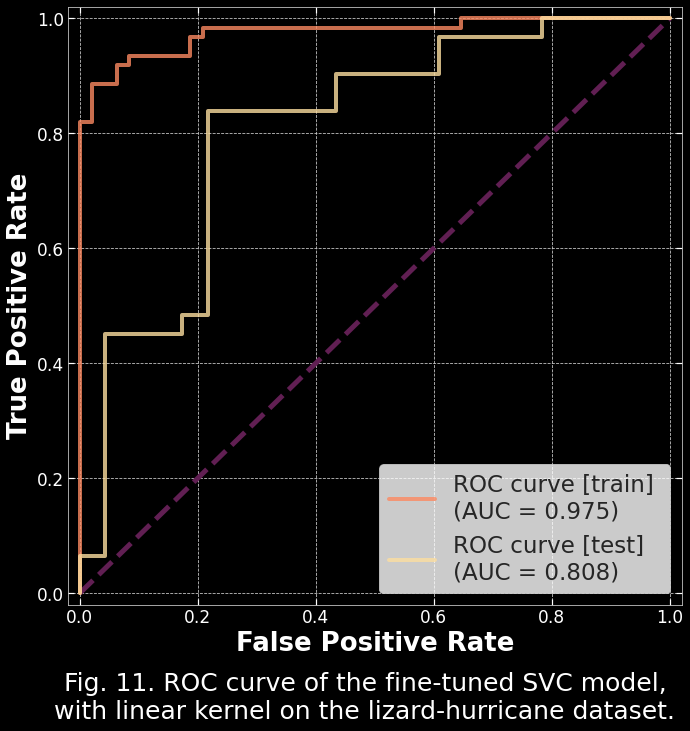

In [47]:
fig, axes = plt.subplots(figsize=(11, 11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot([0, 1], [0, 1], color=rocket_cmap(0.25), lw=5, linestyle='--')

# My model
axes.plot(fpr_tr, tpr_tr,
          label='ROC curve [train] \n(AUC = %0.3f)' % roc_auc_tr,
          color=cm.magma(0.75), lw=4, alpha=0.8)
axes.plot(fpr_ts, tpr_ts,
          label='ROC curve [test] \n(AUC = %0.3f)' % roc_auc_ts,
          color=cm.magma(0.93), lw=4, alpha=0.8)

axes.set_xlim([-0.02, 1.02])
axes.set_ylim([-0.02, 1.02])

axes.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 11. ROC curve of the fine-tuned SVC model,\n' +
             'with {0} kernel on the lizard-hurricane dataset.'.format(kernel),
             fontsize=axistitlesize+5, y=0.04, color='white')
    
plt.show()

### 4./b. Second kernel: `poly`

In [48]:
kernel = 'poly'
clf = fit_SVC(kernel=kernel)

In [49]:
%%time
best_model = clf.fit(X_train, y_train).best_estimator_
print('Best model : {0}'.format(best_model))
y_pred = best_model.predict(X_test)

Best model : SVC(C=7.742636826811246, kernel='poly', random_state=42)
CPU times: user 158 ms, sys: 16 ms, total: 174 ms
Wall time: 690 ms


In [50]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels=[i for i in range(0,2)])

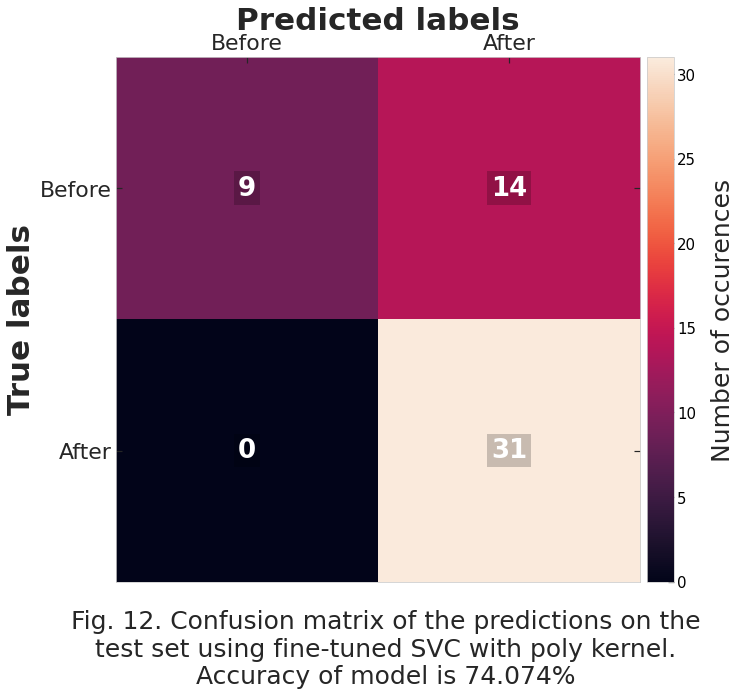

In [51]:
plot_confusion_matrix(conf_mat, y_test, labels=['Before', 'After'],
                      title=('Fig. 12. Confusion matrix of the predictions on the\n' +
                             'test set using fine-tuned SVC with {0} kernel.\n'.format(kernel) +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)),
                     figsize=10)

In [52]:
fpr_tr, tpr_tr, roc_auc_tr = compute_roc(best_model, X_train, y_train)
fpr_ts, tpr_ts, roc_auc_ts = compute_roc(best_model, X_test, y_test)

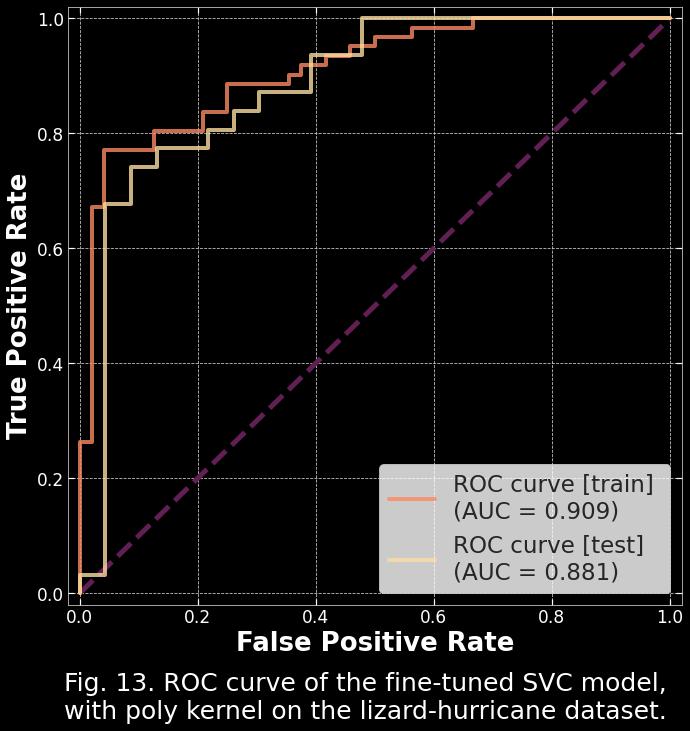

In [53]:
fig, axes = plt.subplots(figsize=(11, 11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot([0, 1], [0, 1], color=rocket_cmap(0.25), lw=5, linestyle='--')

# My model
axes.plot(fpr_tr, tpr_tr,
          label='ROC curve [train] \n(AUC = %0.3f)' % roc_auc_tr,
          color=cm.magma(0.75), lw=4, alpha=0.8)
axes.plot(fpr_ts, tpr_ts,
          label='ROC curve [test] \n(AUC = %0.3f)' % roc_auc_ts,
          color=cm.magma(0.93), lw=4, alpha=0.8)

axes.set_xlim([-0.02, 1.02])
axes.set_ylim([-0.02, 1.02])

axes.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 13. ROC curve of the fine-tuned SVC model,\n' +
             'with {0} kernel on the lizard-hurricane dataset.'.format(kernel),
             fontsize=axistitlesize+5, y=0.04, color='white')
    
plt.show()

### 4./c. Third kernel: `rbf`

In [54]:
kernel = 'rbf'
clf = fit_SVC(kernel=kernel)

In [55]:
%%time
best_model = clf.fit(X_train, y_train).best_estimator_
print('Best model : {0}'.format(best_model))
y_pred = best_model.predict(X_test)

Best model : SVC(C=1e-10, random_state=42)
CPU times: user 172 ms, sys: 4.48 ms, total: 176 ms
Wall time: 705 ms


In [56]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels=[i for i in range(0,2)])

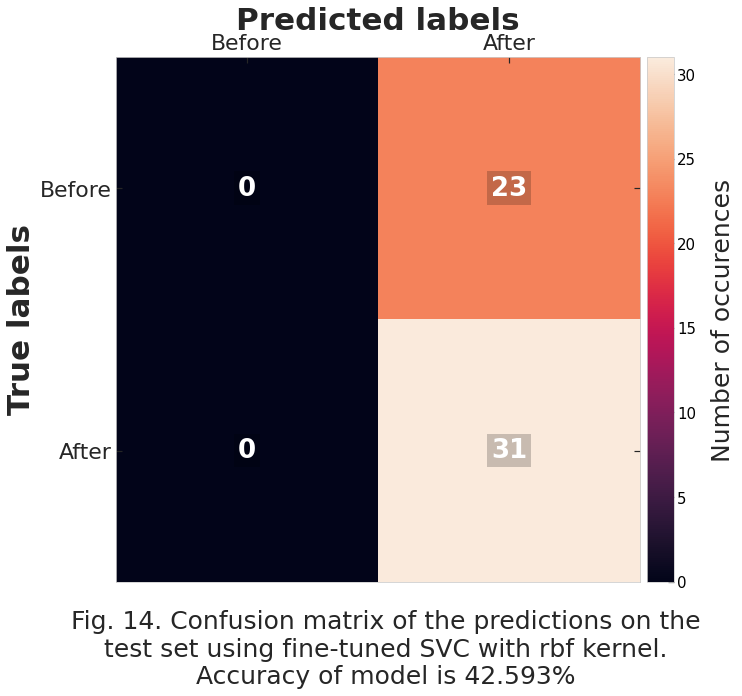

In [57]:
plot_confusion_matrix(conf_mat, y_test, labels=['Before', 'After'],
                      title=('Fig. 14. Confusion matrix of the predictions on the\n' +
                             'test set using fine-tuned SVC with {0} kernel.\n'.format(kernel) +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)),
                     figsize=10)

In [58]:
fpr_tr, tpr_tr, roc_auc_tr = compute_roc(best_model, X_train, y_train)
fpr_ts, tpr_ts, roc_auc_ts = compute_roc(best_model, X_test, y_test)

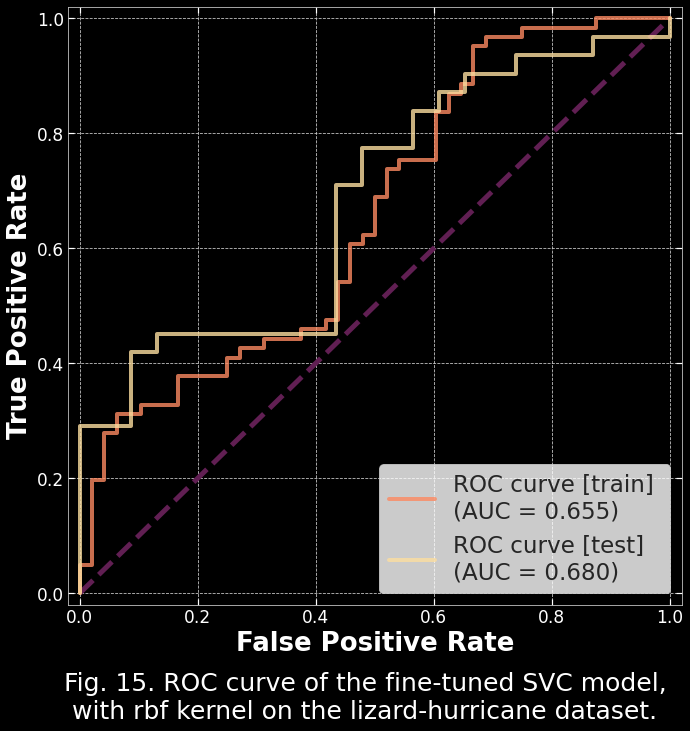

In [59]:
fig, axes = plt.subplots(figsize=(11, 11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot([0, 1], [0, 1], color=rocket_cmap(0.25), lw=5, linestyle='--')

# My model
axes.plot(fpr_tr, tpr_tr,
          label='ROC curve [train] \n(AUC = %0.3f)' % roc_auc_tr,
          color=cm.magma(0.75), lw=4, alpha=0.8)
axes.plot(fpr_ts, tpr_ts,
          label='ROC curve [test] \n(AUC = %0.3f)' % roc_auc_ts,
          color=cm.magma(0.93), lw=4, alpha=0.8)

axes.set_xlim([-0.02, 1.02])
axes.set_ylim([-0.02, 1.02])

axes.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 15. ROC curve of the fine-tuned SVC model,\n' +
             'with {0} kernel on the lizard-hurricane dataset.'.format(kernel),
             fontsize=axistitlesize+5, y=0.04, color='white')
    
plt.show()

### 4./d. Fourth kernel: `sigmoid`

In [60]:
kernel = 'sigmoid'
clf = fit_SVC(kernel=kernel)

In [61]:
%%time
best_model = clf.fit(X_train, y_train).best_estimator_
print('Best model : {0}'.format(best_model))
y_pred = best_model.predict(X_test)

Best model : SVC(C=5.994842503189396, kernel='sigmoid', random_state=42)
CPU times: user 173 ms, sys: 1.16 ms, total: 175 ms
Wall time: 693 ms


In [62]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels=[i for i in range(0,2)])

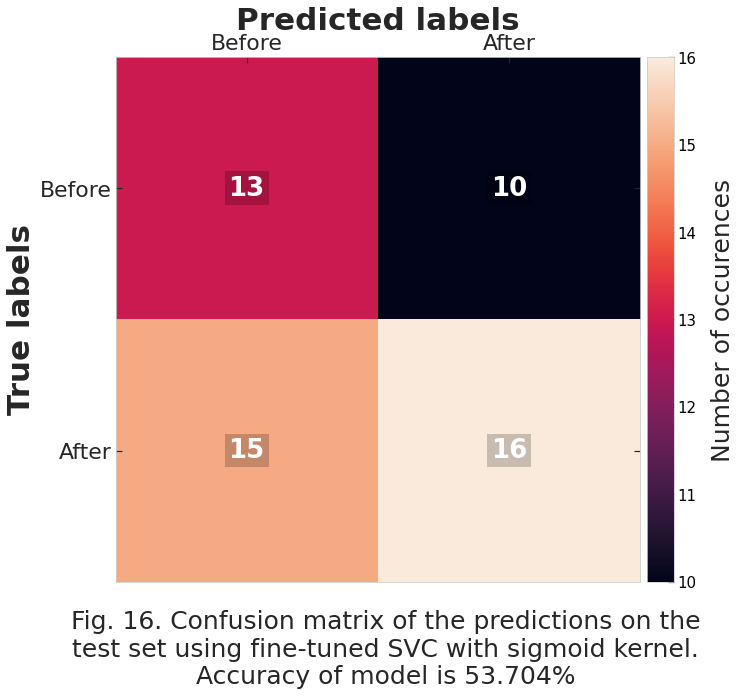

In [63]:
plot_confusion_matrix(conf_mat, y_test, labels=['Before', 'After'],
                      title=('Fig. 16. Confusion matrix of the predictions on the\n' +
                             'test set using fine-tuned SVC with {0} kernel.\n'.format(kernel) +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)),
                     figsize=10)

In [64]:
fpr_tr, tpr_tr, roc_auc_tr = compute_roc(best_model, X_train, y_train)
fpr_ts, tpr_ts, roc_auc_ts = compute_roc(best_model, X_test, y_test)

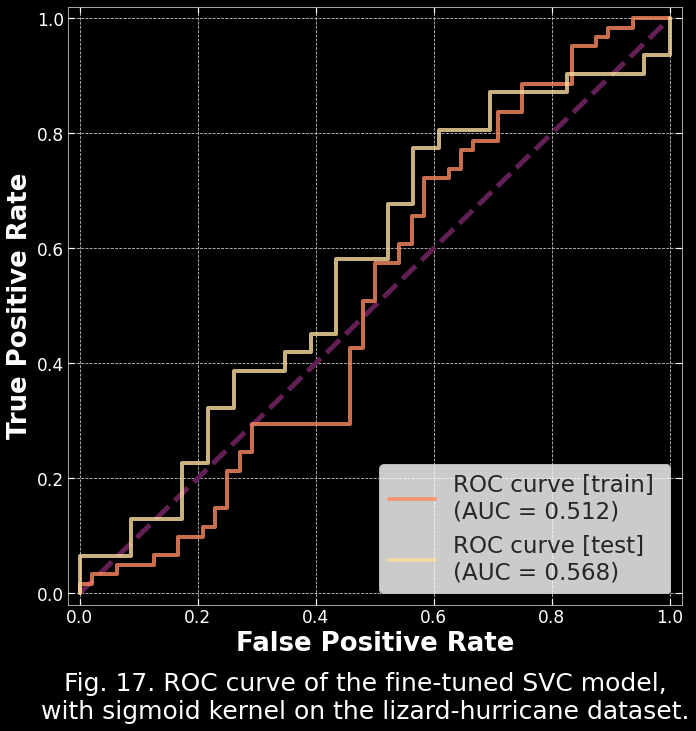

In [65]:
fig, axes = plt.subplots(figsize=(11, 11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot([0, 1], [0, 1], color=rocket_cmap(0.25), lw=5, linestyle='--')

# My model
axes.plot(fpr_tr, tpr_tr,
          label='ROC curve [train] \n(AUC = %0.3f)' % roc_auc_tr,
          color=cm.magma(0.75), lw=4, alpha=0.8)
axes.plot(fpr_ts, tpr_ts,
          label='ROC curve [test] \n(AUC = %0.3f)' % roc_auc_ts,
          color=cm.magma(0.93), lw=4, alpha=0.8)

axes.set_xlim([-0.02, 1.02])
axes.set_ylim([-0.02, 1.02])

axes.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 17. ROC curve of the fine-tuned SVC model,\n' +
             'with {0} kernel on the lizard-hurricane dataset.'.format(kernel),
             fontsize=axistitlesize+5, y=0.04, color='white')
    
plt.show()

### 4./e. Conclusions

So the best kernel for an SVC model was the `poly` kernel. All kernels were tested using the same random seed and all grid search tuning converged within the search interval.

## 5. RF + feature importances
 - train and generate predictions with a random forest classifier model using leave 5 fold cross validation
 - show the ROC curve with the AUC value for the best model that you have found
 - train a random forest model on all the data and show the 5 most important features based on feature importances of the model

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 